# GD2: Augmentation 비교실험(+CutMix, Mixup)

### - 실험 개요
1. 입력 파이프라인 구축   
    - 데이터셋 로드 및 augmentation 기법 구현
    - 4종류의 훈련 데이터셋 생성 : Augmentatinon 미적용, 적용, 적용+cutmix, 적용+mixup
2. 모델 구축 및 훈련
    - ImageNet으로 훈련된 ResNet50에 FC-layer 교체 후 재훈련
3. 훈련 결과 분석
    - Augmentaion 적용 여부에 따른 성능 비교
4. 결론


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

#GPU 확인: Colab > Google Compute Engine 백엔드 (GPU)
tf.config.list_physical_devices('GPU')
# print(tf.__version__)
# print(np.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 입력 파이프라인 구축

### 1-1. 데이터 세트 로드

In [2]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:60%]', 'train[60%:80%]','train[80%:]'],
    shuffle_files=True,
    as_supervised=True, #딕셔너리 대신 튜플 형태를 반환
    with_info=True,
)

#데이터 세트 정보 확인
print(ds_info.features)
print(ds_info.dataset_size)
# print(ds_info.features['label'].names)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})
744.72 MiB


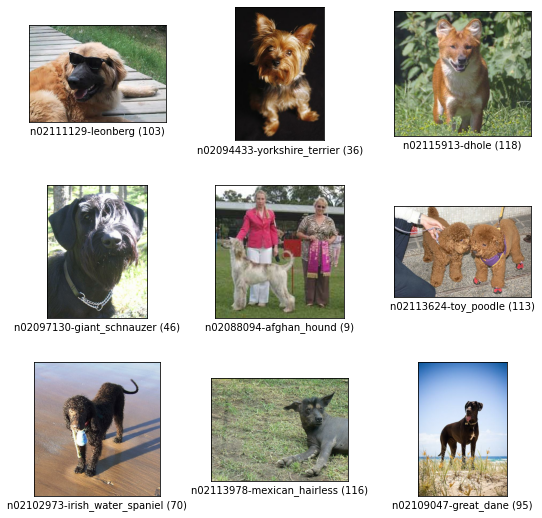

tf.Tensor(7200, shape=(), dtype=int64)
tf.Tensor(2400, shape=(), dtype=int64)
tf.Tensor(2400, shape=(), dtype=int64)


In [3]:
#로드 된 데이터 세트 확인
fig = tfds.show_examples(ds_train,ds_info)
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_val))
print(tf.data.experimental.cardinality(ds_test))

### 1-2. 훈련 및 테스트 파이프라인 구축

### resize, rescale, label one-hot encoding

In [4]:
IMG_SIZE = 128
BATCH_SIZE = 16
NUM_CLASS = 120

#Resize and normalize image
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return tf.cast(image, tf.float32) / 255., label
#Label to onehot-tensor
def onehot(image, label):
    label = tf.one_hot(label, NUM_CLASS,dtype=tf.float32)
    return image, label

### Augmentation-1 : random_flip_left_right, random_brightness

In [5]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

### Augmentation-2 : Cutmix

In [6]:
#image_a에서 랜덤한 바운딩박스 반환
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [7]:
#  image_a의 바운딩 박스를 image_b로 변환
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [8]:
# image_a,b의 면적 비율에 맞게 라벨 변환
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=NUM_CLASS):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_label

In [9]:
#배치 안에서 랜덤한 image_b 반환, cutmix된 이미지를 텐서로 반환
def cutmix(image, label, prob=1.0, batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_classes=NUM_CLASS):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### Augmentation-3 : Mixup

In [10]:
#랜덤 비율로 픽셀값 변환, 비율에 맞게 라벨 변환
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=NUM_CLASS):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [11]:
#배치 안에서 랜덤한 image_b 반환, mixup된 이미지를 텐서로 반환
def mixup(image, label, prob=1.0, batch_size=BATCH_SIZE, img_size=IMG_SIZE, num_classes=NUM_CLASS):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    
    return mixed_imgs, mixed_labels

### Preprocessing : resize, normalize, batch, augmentation, shuffle, prefetch

In [12]:
# AUTOTUNE = tf.data.AUTOTUNE #병렬 처리 수준 자동 지정
AUTOTUNE = 2
# SHUFFLE_SIZE = ds_info.splits['train'].num_examples #모든 train 샘플에 대해 셔플 <<<<<<< 이렇게하면 메모리가 터집니다
SHUFFLE_SIZE = 200


def apply_preprocessing(ds, is_test=False, batch_size=BATCH_SIZE, 
                               with_aug=False, with_cutmix=False, with_mixup=False):
    
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=AUTOTUNE)#all ds resize,rescale
    
    if not is_test and with_aug:#train_aug,cutmix,mixup에서 augmentation
        ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
        
    ds = ds.batch(batch_size)#all ds into batch
    
    if not is_test and with_cutmix:#train_cutmix / cutmix 과정에서 one-hot 진행
        ds = ds.map(cutmix, num_parallel_calls=AUTOTUNE)
    elif not is_test and with_mixup:#train_mixup / mixup 과정에서 one-hot 진행
        ds = ds.map(mixup, num_parallel_calls=AUTOTUNE) 
    else:#train_no_aug, val, test / one-hot 진행
        ds = ds.map(onehot, num_parallel_calls=AUTOTUNE)
        
    if not is_test:#train ds만 repeat/shuffle
        ds = ds.repeat() #훈련 데이터셋 계속 입력 / 이후 steps_per_epoch을 통해 한 epoch을 종료
        ds = ds.shuffle(SHUFFLE_SIZE) #파일 순서가 학습에 영향을 주지 않도록 셔플
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)#all ds prefetch / 입력,훈련 동시 진행
    
    return ds

In [13]:
# 4종류의 훈련 데이터셋 : Augmentatinon 미적용, 적용, 적용+cutmix, 적용+mixup 
ds_train_no_aug = apply_preprocessing(ds_train, with_aug=False)
ds_train_aug = apply_preprocessing(ds_train, with_aug=True)

ds_train_cutmix = apply_preprocessing(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)
ds_train_mixup = apply_preprocessing(ds_train, with_aug=True, with_cutmix=False, with_mixup=True)

ds_val = apply_preprocessing(ds_val, is_test=True)
ds_test = apply_preprocessing(ds_test, is_test=True)

In [14]:
print(ds_train_no_aug.element_spec)
print(ds_train_aug.element_spec)

print(ds_train_cutmix.element_spec)
print(ds_train_mixup.element_spec)

print(ds_val.element_spec)
print(ds_test.element_spec)

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))
(TensorSpec(shape=(16, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))
(TensorSpec(shape=(16, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 120), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.float32, name=None))


## 2. 모델 구축 및 훈련

### 1. no augment

In [15]:
EPOCH = 15
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE,IMG_SIZE,3),
        pooling='avg',
    ),
    keras.layers.Dense(NUM_CLASS, activation='softmax')
])
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50 = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/15
750/750 [==============================] - ETA: 0s - loss: 2.7367 - accuracy: 0.3658WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 536 batches). You may need to use the repeat() function when building your dataset.


750/750 [==============================] - 111s 75ms/step - loss: 2.7367 - accuracy: 0.3658 - val_loss: 4.2102 - val_accuracy: 0.1042
Epoch 2/15
750/750 [==============================] - 52s 69ms/step - loss: 0.5061 - accuracy: 0.8919
Epoch 3/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0557 - accuracy: 0.9965
Epoch 4/15
750/750 [==============================] - 52s 70ms/step - loss: 0.0196 - accuracy: 0.9994
Epoch 5/15
750/750 [==============================] - 52s 70ms/step - loss: 0.0124 - accuracy: 0.9996
Epoch 6/15
750/750 [==============================] - 52s 70ms/step - loss: 0.0108 - accuracy: 0.9998
Epoch 7/15
750/750 [==============================] - 52s 70ms/step - loss: 0.0087 - accuracy: 0.9998
Epoch 8/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0072 - accuracy: 0.9998
Epoch 9/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0060 - accuracy: 0.9999
Epoch 10/15
750/750 [=============================

### 2. with augment

In [24]:
EPOCH = 15
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE,IMG_SIZE,3),
        pooling='avg',
    ),
    keras.layers.Dense(NUM_CLASS, activation='softmax')
])
resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - ETA: 0s - loss: 2.8452 - accuracy: 0.3329WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 536 batches). You may need to use the repeat() function when building your dataset.


750/750 [==============================] - 63s 76ms/step - loss: 2.8452 - accuracy: 0.3329 - val_loss: 4.1319 - val_accuracy: 0.1108
Epoch 2/15
750/750 [==============================] - 53s 70ms/step - loss: 0.9628 - accuracy: 0.7552
Epoch 3/15
750/750 [==============================] - 53s 70ms/step - loss: 0.3047 - accuracy: 0.9378
Epoch 4/15
750/750 [==============================] - 53s 70ms/step - loss: 0.1155 - accuracy: 0.9837
Epoch 5/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0570 - accuracy: 0.9935
Epoch 6/15
750/750 [==============================] - 53s 71ms/step - loss: 0.0344 - accuracy: 0.9975
Epoch 7/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0187 - accuracy: 0.9991
Epoch 8/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0137 - accuracy: 0.9993
Epoch 9/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0112 - accuracy: 0.9993
Epoch 10/15
750/750 [==============================

### 3. with augment + cutmix

In [25]:
EPOCH = 15
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE,IMG_SIZE,3),
        pooling='avg',
    ),
    keras.layers.Dense(NUM_CLASS, activation='softmax')
])
resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - ETA: 0s - loss: 4.3514 - accuracy: 0.0994WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 536 batches). You may need to use the repeat() function when building your dataset.


750/750 [==============================] - 65s 76ms/step - loss: 4.3514 - accuracy: 0.0994 - val_loss: 4.6218 - val_accuracy: 0.0571
Epoch 2/15
750/750 [==============================] - 53s 70ms/step - loss: 3.5362 - accuracy: 0.2736
Epoch 3/15
750/750 [==============================] - 53s 71ms/step - loss: 3.1893 - accuracy: 0.3783
Epoch 4/15
750/750 [==============================] - 53s 70ms/step - loss: 2.9224 - accuracy: 0.4675
Epoch 5/15
750/750 [==============================] - 53s 70ms/step - loss: 2.7369 - accuracy: 0.5270
Epoch 6/15
750/750 [==============================] - 53s 71ms/step - loss: 2.5796 - accuracy: 0.5778
Epoch 7/15
750/750 [==============================] - 53s 71ms/step - loss: 2.4185 - accuracy: 0.6364
Epoch 8/15
750/750 [==============================] - 53s 70ms/step - loss: 2.3178 - accuracy: 0.6628
Epoch 9/15
750/750 [==============================] - 53s 71ms/step - loss: 2.2362 - accuracy: 0.6957
Epoch 10/15
750/750 [==============================

### 4. with augment + mixup

In [26]:
EPOCH = 15
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE,IMG_SIZE,3),
        pooling='avg',
    ),
    keras.layers.Dense(NUM_CLASS, activation='softmax')
])
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - ETA: 0s - loss: 4.2078 - accuracy: 0.1347WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 536 batches). You may need to use the repeat() function when building your dataset.


750/750 [==============================] - 62s 74ms/step - loss: 4.2078 - accuracy: 0.1347 - val_loss: 5.4394 - val_accuracy: 0.0200
Epoch 2/15
750/750 [==============================] - 53s 71ms/step - loss: 3.3068 - accuracy: 0.3464
Epoch 3/15
750/750 [==============================] - 53s 70ms/step - loss: 2.9659 - accuracy: 0.4626
Epoch 4/15
750/750 [==============================] - 53s 71ms/step - loss: 2.7082 - accuracy: 0.5649
Epoch 5/15
750/750 [==============================] - 53s 70ms/step - loss: 2.4870 - accuracy: 0.6329
Epoch 6/15
750/750 [==============================] - 53s 70ms/step - loss: 2.3696 - accuracy: 0.6800
Epoch 7/15
750/750 [==============================] - 53s 70ms/step - loss: 2.2435 - accuracy: 0.7272
Epoch 8/15
750/750 [==============================] - 53s 70ms/step - loss: 2.1496 - accuracy: 0.7655
Epoch 9/15
750/750 [==============================] - 53s 70ms/step - loss: 2.0999 - accuracy: 0.7795
Epoch 10/15
750/750 [==============================

In [30]:
#모델 저장
resnet50.save('./aiffel/project/resnet50')
resnet50_aug.save('./aiffel/project/resnet50__aug')
resnet50_cutmix.save('./aiffel/project/resnet50_cutmix')
resnet50_mixup.save('./aiffel/project/resnet50_mixup')

INFO:tensorflow:Assets written to: ./aiffel/project/resnet50/assets


INFO:tensorflow:Assets written to: ./aiffel/project/resnet50/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./aiffel/project/resnet50__aug/assets


INFO:tensorflow:Assets written to: ./aiffel/project/resnet50__aug/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./aiffel/project/resnet50_cutmix/assets


INFO:tensorflow:Assets written to: ./aiffel/project/resnet50_cutmix/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: ./aiffel/project/resnet50_mixup/assets


INFO:tensorflow:Assets written to: ./aiffel/project/resnet50_mixup/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## 3. 훈련 결과 분석

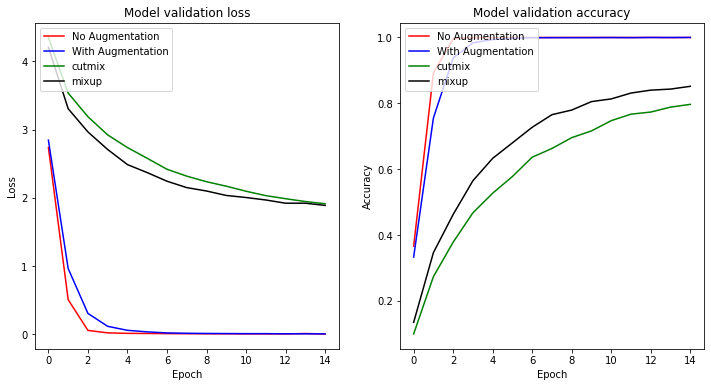

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50.history['loss'], 'r')
ax1.plot(history_resnet50_aug.history['loss'], 'b')
ax1.plot(history_resnet50_cutmix.history['loss'], 'g')
ax1.plot(history_resnet50_mixup.history['loss'], 'k')
ax1.set_title('Model validation loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')

ax2.plot(history_resnet50.history['accuracy'], 'r')
ax2.plot(history_resnet50_aug.history['accuracy'], 'b')
ax2.plot(history_resnet50_cutmix.history['accuracy'], 'g')
ax2.plot(history_resnet50_mixup.history['accuracy'], 'k')
ax2.set_title('Model validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')

plt.show()

- 학습속도 비교   
학습속도가 느린 원인을 추정해보면, augmentataion 기법이 원본 데이터셋의 다양성?복잡도?를 늘리기 때문인 것 같다.   
no_aug와 aug에서도 학습속도의 차이가 보이고, cutmix와 mixup은 변형이 많이 이루어지기 때문에 이러한 효과가 두드러지는 것 같다.
- loss/accuracy 비교   
Cutmix/Mixup은 loss/accuracy 모두 충분히 수렴하지 않아 학습이 더 필요해보인다.
no_aug/aug의 경우 수렴하는 구간을 확대해 보았다(아래).
- Cutmix/Mixup의 loss가 수렴하는 구간이 no_aug/aug와 차이를 보이는 이유
    1. Cutmix/Mixup를 적용하면 더 복잡한 모델이 요구되거나,
    2. saddle point(안장점)에서 학습이 정체되어 있는 경우,
위의 두가지 경우가 있을 수 있는데, cutmix 논문에서 150epoch 이후 다시 급격히 감소하는 것으로 보아, saddle point 문제인 것 같다.
현재 사용한 옵티마이저가 SGD인데, adam으로 바꾸어 주는 것도 방법이 될 수 있을 것 같다.

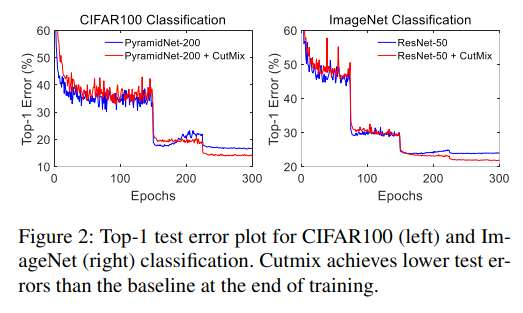

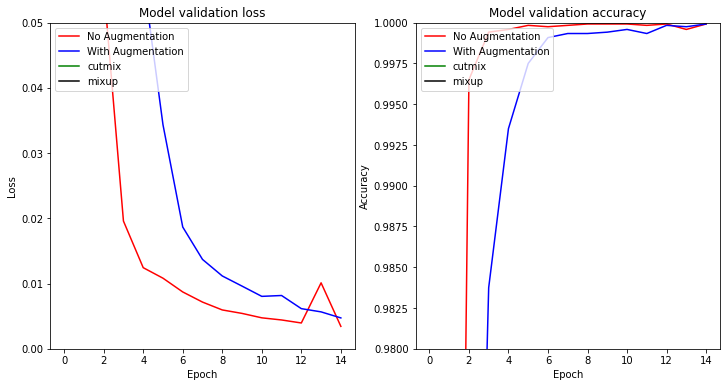

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50.history['loss'], 'r')
ax1.plot(history_resnet50_aug.history['loss'], 'b')
ax1.plot(history_resnet50_cutmix.history['loss'], 'g')
ax1.plot(history_resnet50_mixup.history['loss'], 'k')
ax1.set_ylim([0.00, 0.05])
ax1.set_title('Model validation loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')

ax2.plot(history_resnet50.history['accuracy'], 'r')
ax2.plot(history_resnet50_aug.history['accuracy'], 'b')
ax2.plot(history_resnet50_cutmix.history['accuracy'], 'g')
ax2.plot(history_resnet50_mixup.history['accuracy'], 'k')
ax2.set_ylim([0.98, 1])
ax2.set_title('Model validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')

plt.show()

교차하는 구간이 있어서 no_aug와 aug도 더 학습해보았다.

### 추가 학습

In [35]:
resnet50_15_epoch = keras.models.load_model('./aiffel/project/resnet50')

EPOCH2=15

history_resnet50_15_epoch = resnet50_15_epoch.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH2,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/15
750/750 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 536 batches). You may need to use the repeat() function when building your dataset.


750/750 [==============================] - 61s 73ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.2471 - val_accuracy: 0.4796
Epoch 2/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0026 - accuracy: 0.9999
Epoch 3/15
750/750 [==============================] - 52s 70ms/step - loss: 0.0029 - accuracy: 0.9998
Epoch 4/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0026 - accuracy: 0.9998
Epoch 5/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0024 - accuracy: 0.9999
Epoch 6/15
750/750 [==============================] - 52s 70ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 7/15
750/750 [==============================] - 52s 70ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 8/15
750/750 [==============================] - 52s 70ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 9/15
750/750 [==============================] - 52s 70ms/step - loss: 0.0027 - accuracy: 0.9999
Epoch 10/15
750/750 [==============================

In [38]:
resnet50_aug_15_epoch = keras.models.load_model('./aiffel/project/resnet50__aug')

EPOCH2=15

history_resnet50_aug_15_epoch = resnet50_aug_15_epoch.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH2,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 1.0000WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 536 batches). You may need to use the repeat() function when building your dataset.


750/750 [==============================] - 63s 76ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.1788 - val_accuracy: 0.4946
Epoch 2/15
750/750 [==============================] - 53s 71ms/step - loss: 0.0138 - accuracy: 0.9991
Epoch 3/15
750/750 [==============================] - 53s 71ms/step - loss: 0.0067 - accuracy: 0.9995
Epoch 4/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0048 - accuracy: 0.9997
Epoch 5/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0037 - accuracy: 0.9998
Epoch 6/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0052 - accuracy: 0.9999
Epoch 7/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0041 - accuracy: 0.9998
Epoch 8/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0076 - accuracy: 0.9991
Epoch 9/15
750/750 [==============================] - 53s 70ms/step - loss: 0.0040 - accuracy: 0.9998
Epoch 10/15
750/750 [==============================

In [39]:
resnet50_cutmix_15_epoch = keras.models.load_model('./aiffel/project/resnet50_cutmix')

EPOCH2=15

history_resnet50_cutmix_15_epoch = resnet50_cutmix_15_epoch.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH2,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - ETA: 0s - loss: 1.8812 - accuracy: 0.8048WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 536 batches). You may need to use the repeat() function when building your dataset.


750/750 [==============================] - 64s 77ms/step - loss: 1.8812 - accuracy: 0.8048 - val_loss: 2.5519 - val_accuracy: 0.4150
Epoch 2/15
750/750 [==============================] - 53s 70ms/step - loss: 1.8451 - accuracy: 0.8148
Epoch 3/15
750/750 [==============================] - 53s 71ms/step - loss: 1.8152 - accuracy: 0.8287
Epoch 4/15
750/750 [==============================] - 53s 70ms/step - loss: 1.7931 - accuracy: 0.8363
Epoch 5/15
750/750 [==============================] - 53s 70ms/step - loss: 1.7761 - accuracy: 0.8392
Epoch 6/15
750/750 [==============================] - 53s 70ms/step - loss: 1.7554 - accuracy: 0.8388
Epoch 7/15
750/750 [==============================] - 53s 71ms/step - loss: 1.7351 - accuracy: 0.8462
Epoch 8/15
750/750 [==============================] - 53s 70ms/step - loss: 1.7166 - accuracy: 0.8480
Epoch 9/15
750/750 [==============================] - 53s 70ms/step - loss: 1.6828 - accuracy: 0.8575
Epoch 10/15
750/750 [==============================

In [40]:
resnet50_mixup_15_epoch = keras.models.load_model('./aiffel/project/resnet50_mixup')

EPOCH2=15

history_resnet50_mixup_15_epoch = resnet50_mixup_15_epoch.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH2,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
750/750 [==============================] - ETA: 0s - loss: 1.8773 - accuracy: 0.8546WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 536 batches). You may need to use the repeat() function when building your dataset.


750/750 [==============================] - 63s 76ms/step - loss: 1.8773 - accuracy: 0.8546 - val_loss: 2.4552 - val_accuracy: 0.4296
Epoch 2/15
750/750 [==============================] - 53s 70ms/step - loss: 1.8707 - accuracy: 0.8558
Epoch 3/15
750/750 [==============================] - 53s 70ms/step - loss: 1.8375 - accuracy: 0.8633
Epoch 4/15
750/750 [==============================] - 53s 70ms/step - loss: 1.8207 - accuracy: 0.8651
Epoch 5/15
750/750 [==============================] - 53s 70ms/step - loss: 1.8253 - accuracy: 0.8633
Epoch 6/15
750/750 [==============================] - 53s 70ms/step - loss: 1.7975 - accuracy: 0.8701
Epoch 7/15
750/750 [==============================] - 53s 70ms/step - loss: 1.7833 - accuracy: 0.8750
Epoch 8/15
750/750 [==============================] - 53s 70ms/step - loss: 1.7685 - accuracy: 0.8725
Epoch 9/15
750/750 [==============================] - 53s 70ms/step - loss: 1.7386 - accuracy: 0.8825
Epoch 10/15
750/750 [==============================

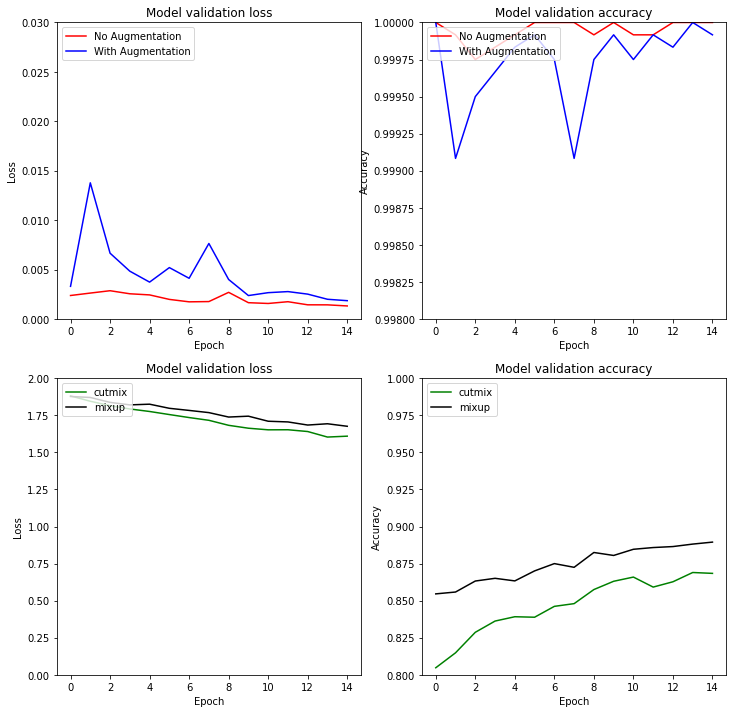

In [48]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(12, 12))

ax1.plot(history_resnet50_15_epoch.history['loss'], 'r')
ax1.plot(history_resnet50_aug_15_epoch.history['loss'], 'b')
ax1.set_ylim([0.00, 0.03])
ax1.set_title('Model validation loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['No Augmentation', 'With Augmentation'], loc='upper left')

ax3.plot(history_resnet50_cutmix_15_epoch.history['loss'], 'g')
ax3.plot(history_resnet50_mixup_15_epoch.history['loss'], 'k')
ax3.set_ylim([0.00, 2.0])
ax3.set_title('Model validation loss')
ax3.set_ylabel('Loss')
ax3.set_xlabel('Epoch')
ax3.legend(['cutmix', 'mixup'], loc='upper left')

ax2.plot(history_resnet50_15_epoch.history['accuracy'], 'r')
ax2.plot(history_resnet50_aug_15_epoch.history['accuracy'], 'b')
ax2.set_ylim([0.998, 1.0])
ax2.set_title('Model validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['No Augmentation', 'With Augmentation'], loc='upper left')

ax4.plot(history_resnet50_cutmix_15_epoch.history['accuracy'], 'g')
ax4.plot(history_resnet50_mixup_15_epoch.history['accuracy'], 'k')
ax4.set_ylim([0.8, 1.0])
ax4.set_title('Model validation accuracy')
ax4.set_ylabel('Accuracy')
ax4.set_xlabel('Epoch')
ax4.legend(['cutmix', 'mixup'], loc='upper left')


plt.show()

## 4. 결론

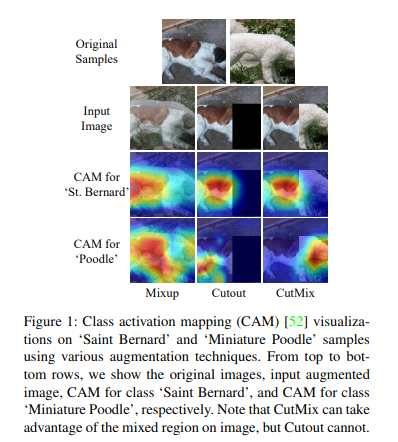

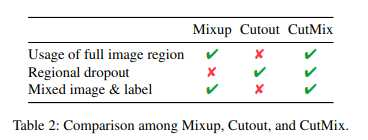

- 모델 학습에 대해
    - Cutmix, Mixup은 더 학습할 여지가 남았지만, 시간 관계상 중단했다.
    - 이후 옵티마이저를 SGD에서 Adam으로, 200epoch 까지 학습하면 더 좋은 결과를 낼 수 있을 것 같다.
    - 이번 실험에서는 augmentation 성능을 비교하기 위해 사전학습된 모델의 모든 레이어를 재학습했지만, 실제로 샘플이 적어서 augmentation을 사용하는 경우, 분류기만 학습하는 방법을 통해 시간을 단축할 수 있을 것 같다.
- 성능 비교
    - 실험에서는 확인하지 못했지만, 논문에 의하면 Cutmix가 제일 좋다고 하고, CAM을 통해 이를 분석했다.
- 파이프라인 구축에 대해
    - batch단위로 augmentation을 적용하는 대신, 새롭게 변환된 이미지들을 원본 이미지에 더해 데이터셋 자체를 키우고 학습하면 더 성능이 좋아지는지 비교하면 좋을 것 같다.
    - suffle size를 키우면 더 좋다고 나와있는데 키웠더니 메모리가 터졌다. cache,prefetch,병렬화등 메모리 사용 및 최적화에 대해 알아봐야겠다.


### 5. Tranfer learning 실험(feature extraction)

In [52]:
#Pre-trained model(ResNet50, ImageNet) 가져오기
base_model = keras.applications.resnet.ResNet50(
        include_top=False, #use only feature extractor, not classifier
        weights='imagenet',
        input_shape=(IMG_SIZE,IMG_SIZE,3),
        pooling='avg'
    )

base_model.trainable = False #use only feature extractor, not classifier
# base_model.summary()

In [54]:
def create_model():
    inputs = keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), batch_size=BATCH_SIZE)
    x = base_model(inputs, training=False)
#     x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(NUM_CLASS, activation='softmax')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

resnet50_cutmix_pre = create_model()
resnet50_cutmix_pre.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(16, 128, 128, 3)]       0         
_________________________________________________________________
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_8 (Dense)              (16, 120)                 245880    
Total params: 23,833,592
Trainable params: 245,880
Non-trainable params: 23,587,712
_________________________________________________________________


In [55]:
resnet50_cutmix_pre.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy'],
)

In [ ]:
EPOCH=20
BATCH_SIZE=16
history_resnet50_cutmix_pre = resnet50_cutmix_pre.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
263/750 [=========>....................] - ETA: 11s - loss: 5.3251 - accuracy: 0.0083